<a href="https://colab.research.google.com/github/fuat-arslan/Pytorch_Scratch/blob/main/Diffusion/I2SB_Highlighted_Codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the I2SB implementation turned to ipynb version [original code](https://github.com/NVlabs/I2SB/tree/master).

This notebook only highlights their contribution to SGM and mathematically imprtant details. It is not intended to run and train. This seems imposible in the Colab envirornment. Even that U-Net cannot be used for inference due to RAM constraints.

#Imports

In [32]:
import numpy as np
from tqdm import tqdm
from functools import partial
import torch
import pickle
import os

#Helpers

In [12]:
def unsqueeze_xdim(z, xdim):
    bc_dim = (...,) + (None,) * len(xdim)
    return z[bc_dim]

In [18]:
to_torch = partial(torch.tensor, dtype=torch.float32)

#Sampling

below is the beta scheduler

In [2]:
def make_beta_schedule(n_timestep=1000, linear_start=1e-4, linear_end=2e-2):
    # return np.linspace(linear_start, linear_end, n_timestep)
    betas = (
        torch.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timestep, dtype=torch.float64) ** 2
    )
    return betas.numpy()

In [4]:
smp_betas = make_beta_schedule()
smp_betas.shape, smp_betas[0:10]

((1000,),
 array([0.0001    , 0.00010265, 0.00010533, 0.00010805, 0.0001108 ,
        0.00011359, 0.00011641, 0.00011927, 0.00012216, 0.00012508]))

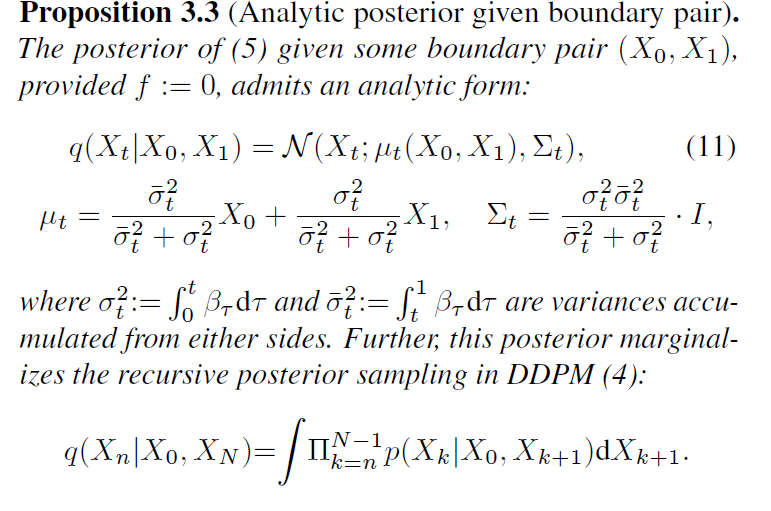

It is statted in the paper that this is the analytic posterior of SB given the boundary (X0,X1). This sampling method is their contrubition to make calulcation tratabel in the DDPM framework. Below they will calculate the corresponidng coefficents of the bounderies for sampling.

In [19]:
def calculate_coeff(betas):
    """
    It takes betas and calculates sigmas im the above formule (11 in the paper)
    returns sigmas and coefficents that will help to calculate mu for the spesfic
    time step.
    """

    std_fwd = np.sqrt(np.cumsum(betas)) #sigma
    std_bwd = np.sqrt(np.flip(np.cumsum(np.flip(betas)))) #sigma bar

    denom = std_fwd**2 + std_bwd**2
    coeffX0 = std_bwd**2 / denom
    coeffX1 = std_fwd**2 / denom
    var = (std_fwd**2 * std_bwd**2) / denom

    return to_torch(std_fwd), to_torch(std_bwd), to_torch(coeffX0), to_torch(coeffX1), to_torch(var)


In [20]:
#Simple check

std_fwd, std_bwd, coeffX0, coeffX0, var = calculate_coeff(smp_betas)
std_fwd[0:2], std_bwd[0:2]


(tensor([0.0100, 0.0142]), tensor([2.6785, 2.6785]))

Lets now sample from the q distribution. These X0s are clean images indeed what we want to recover from corrpted X1. Thus all the inputs are images.

In [21]:
def q_sample(step, x0, x1, ot_ode=False):
        """ Sample q(x_t | x_0, x_1), i.e. eq 11 """

        assert x0.shape == x1.shape
        batch, *xdim = x0.shape

        mu_x0  = unsqueeze_xdim(coeffX0[step],  xdim)
        mu_x1  = unsqueeze_xdim(coeffX0[step],  xdim)
        std_sb = unsqueeze_xdim(np.sqrt(var)[step], xdim)

        xt = mu_x0 * x0 + mu_x1 * x1
        if not ot_ode:
            xt = xt + std_sb * torch.randn_like(xt)
        return xt.detach()

In [22]:
#Quick Test

x0 = torch.randn((32,3,256,256))
x1 = torch.randn((32,3,256,256))
step = torch.randint(0, len(smp_betas), (x0.shape[0],))

xt = q_sample(step, x0, x1)



Above code is one of the most important trick that they made. Now This method allow them to use nonlinear SDE for sampling. This is different from the normal diffusion.

**Please just run below code and pass it retrives pretrained U-*Net***

#Network

In this part they use pretrained U-Net which I too will copy and paste.

In [28]:
pip -q install guided-diffusion-sdk

In [27]:
from guided_diffusion.script_util import create_model

In [47]:
from argparse import Namespace
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model,
    args_to_dict,
)
import requests

In [23]:
ADM_IMG256_UNCOND_CKPT = "https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt"
I2SB_IMG256_UNCOND_PKL = "256x256_diffusion_uncond_fixedsigma.pkl"
I2SB_IMG256_UNCOND_CKPT = "256x256_diffusion_uncond_fixedsigma.pt"
I2SB_IMG256_COND_PKL = "256x256_diffusion_cond_fixedsigma.pkl"
I2SB_IMG256_COND_CKPT = "256x256_diffusion_cond_fixedsigma.pt"

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [38]:
def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)

In [44]:
def create_argparser():
    return Namespace(
        attention_resolutions='32,16,8',
        batch_size=4,
        channel_mult='',
        class_cond=False,
        clip_denoised=True,
        diffusion_steps=1000,
        dropout=0.0,
        image_size=256,
        learn_sigma=True,
        adm_ckpt='256x256_diffusion_uncond.pt',
        noise_schedule='linear',
        num_channels=256,
        num_head_channels=64,
        num_heads=4,
        num_heads_upsample=-1,
        num_res_blocks=2,
        num_samples=4,
        predict_xstart=False,
        resblock_updown=True,
        rescale_learned_sigmas=False,
        rescale_timesteps=False,
        timestep_respacing='250',
        use_checkpoint=False,
        use_ddim=False,
        use_fp16=True,
        use_kl=False,
        use_new_attention_order=False,
        use_scale_shift_norm=True
    )


def extract_model_kwargs(kwargs):
    return {
        "image_size": kwargs["image_size"],
        "num_channels": kwargs["num_channels"],
        "num_res_blocks": kwargs["num_res_blocks"],
        "channel_mult": kwargs["channel_mult"],
        "learn_sigma": kwargs["learn_sigma"],
        "class_cond": kwargs["class_cond"],
        "use_checkpoint": kwargs["use_checkpoint"],
        "attention_resolutions": kwargs["attention_resolutions"],
        "num_heads": kwargs["num_heads"],
        "num_head_channels": kwargs["num_head_channels"],
        "num_heads_upsample": kwargs["num_heads_upsample"],
        "use_scale_shift_norm": kwargs["use_scale_shift_norm"],
        "dropout": kwargs["dropout"],
        "resblock_updown": kwargs["resblock_updown"],
        "use_fp16": kwargs["use_fp16"],
        "use_new_attention_order": kwargs["use_new_attention_order"],
    }

In [45]:
def download_adm_image256_uncond_ckpt(ckpt_dir="data/"):
    ckpt_pkl = os.path.join(ckpt_dir, I2SB_IMG256_UNCOND_PKL)
    ckpt_pt  = os.path.join(ckpt_dir, I2SB_IMG256_UNCOND_CKPT)
    if os.path.exists(ckpt_pkl) and os.path.exists(ckpt_pt):
        return

    opt = create_argparser()

    adm_ckpt = os.path.join(ckpt_dir, opt.adm_ckpt)
    if not os.path.exists(adm_ckpt):
        print("Downloading ADM checkpoint to {} ...".format(adm_ckpt))
        download(ADM_IMG256_UNCOND_CKPT, adm_ckpt)
    ckpt_state_dict = torch.load(adm_ckpt, map_location="cpu")

    # pt: remove the sigma prediction
    ckpt_state_dict["out.2.weight"] = ckpt_state_dict["out.2.weight"][:3]
    ckpt_state_dict["out.2.bias"] = ckpt_state_dict["out.2.bias"][:3]
    torch.save(ckpt_state_dict, ckpt_pt)

    # pkl
    kwargs = args_to_dict(opt, model_and_diffusion_defaults().keys())
    kwargs['learn_sigma'] = False
    model_kwargs = extract_model_kwargs(kwargs)
    with open(ckpt_pkl, "wb") as f:
        pickle.dump(model_kwargs, f)

    print(f"Saved adm uncond pretrain models at {ckpt_pkl=} and {ckpt_pt}!")

In [35]:
class Image256Net(torch.nn.Module):
    def __init__(self, noise_levels, use_fp16=False, cond=False, pretrained_adm=True, ckpt_dir="data/"):
        super(Image256Net, self).__init__()

        # initialize model
        ckpt_pkl = os.path.join(ckpt_dir, I2SB_IMG256_COND_PKL if cond else I2SB_IMG256_UNCOND_PKL)
        with open(ckpt_pkl, "rb") as f:
            kwargs = pickle.load(f)
        kwargs["use_fp16"] = use_fp16
        self.diffusion_model = create_model(**kwargs)


        # load (modified) adm ckpt
        if pretrained_adm:
            ckpt_pt = os.path.join(ckpt_dir, I2SB_IMG256_COND_CKPT if cond else I2SB_IMG256_UNCOND_CKPT)
            out = torch.load(ckpt_pt, map_location="cpu")
            self.diffusion_model.load_state_dict(out)


        self.diffusion_model.eval()
        self.cond = cond
        self.noise_levels = noise_levels

    def forward(self, x, steps, cond=None):

        t = self.noise_levels[steps].detach()
        assert t.dim()==1 and t.shape[0] == x.shape[0]

        x = torch.cat([x, cond], dim=1) if self.cond else x
        return self.diffusion_model(x, t)

In [48]:
download_adm_image256_uncond_ckpt()

2.21GB [01:03, 34.8MB/s]                            


Saved adm uncond pretrain models at ckpt_pkl='data/256x256_diffusion_uncond_fixedsigma.pkl' and data/256x256_diffusion_uncond_fixedsigma.pt!


In [49]:
noise_levels = torch.linspace(1e-4, 1., 1000) * 1000

net = Image256Net(noise_levels=noise_levels)

In [ ]:
net

This network taken from followed [paper](https://arxiv.org/pdf/2105.05233.pdf). Tkane U-Net from below architecture.

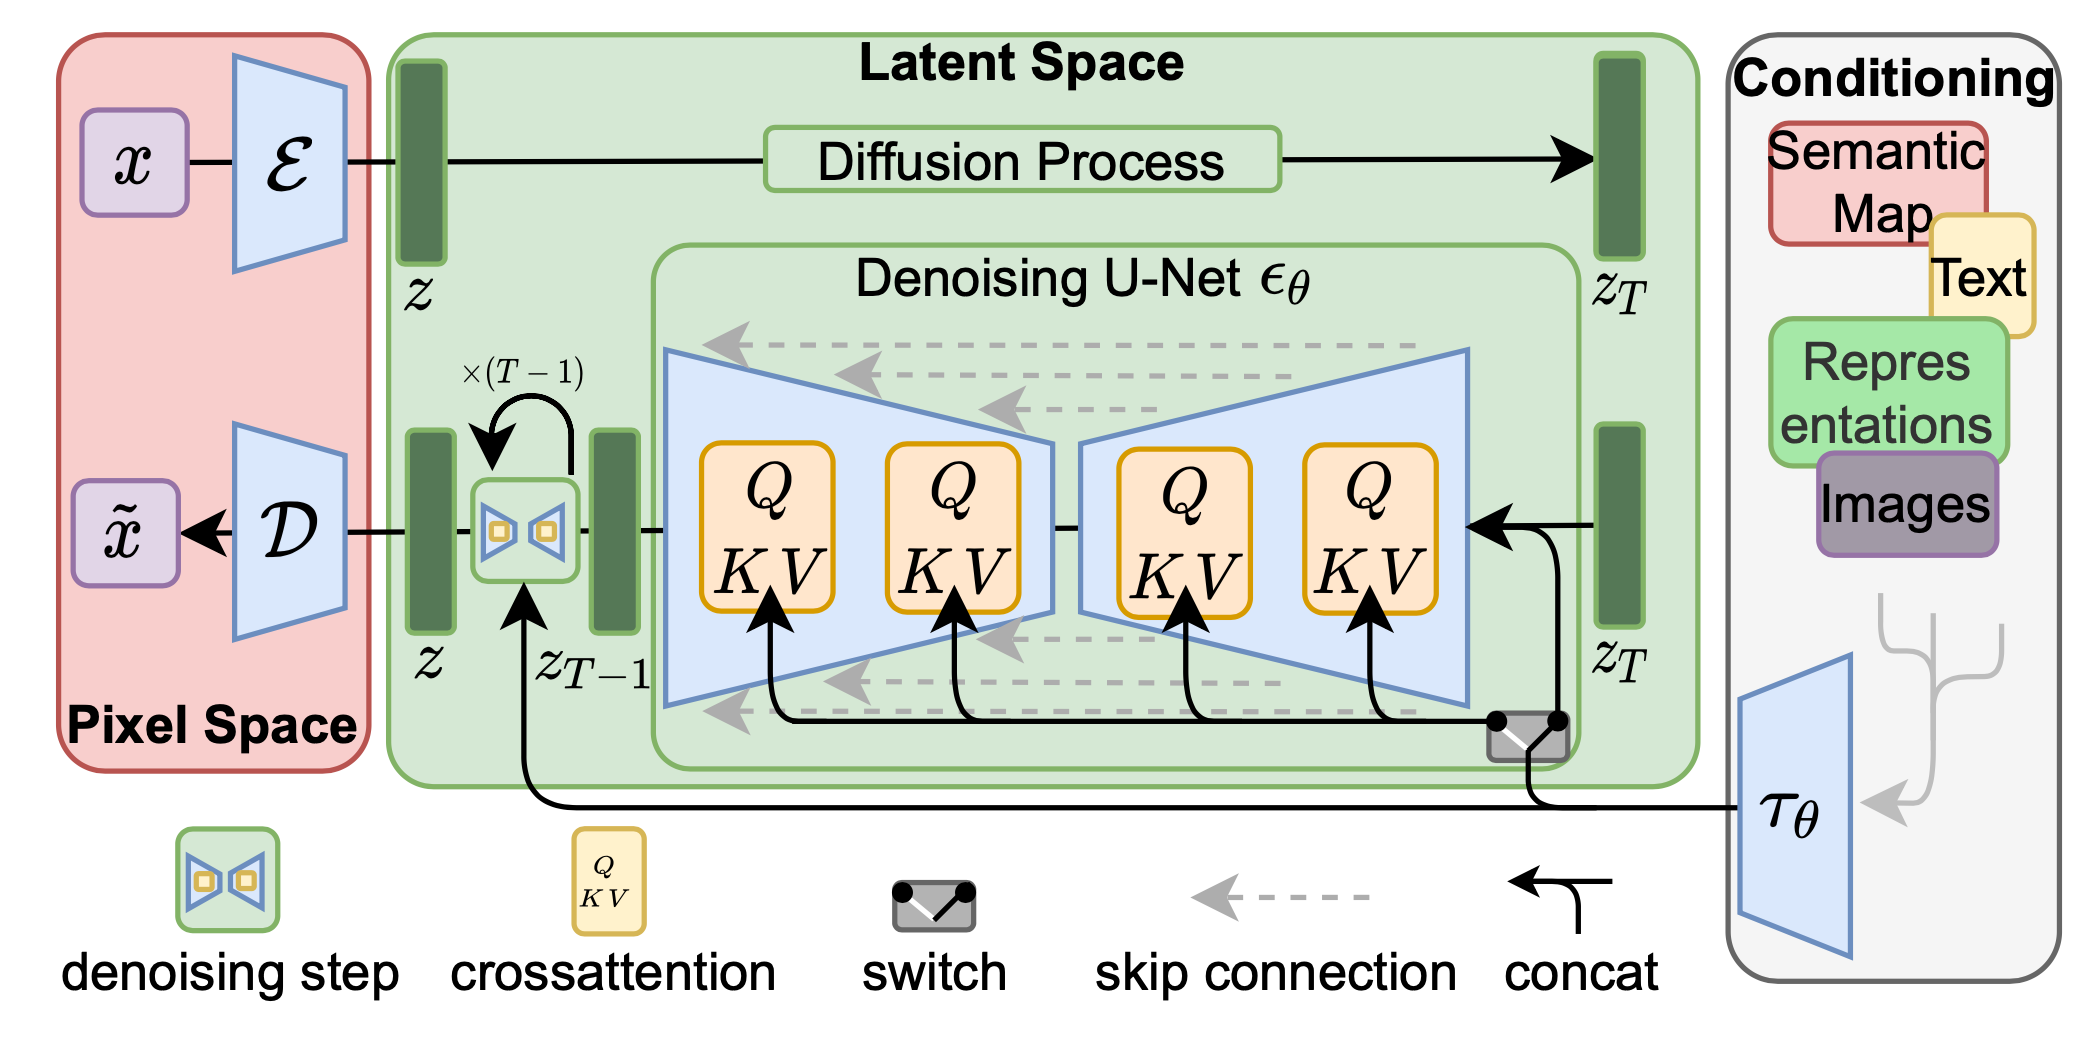

#Calculate Label

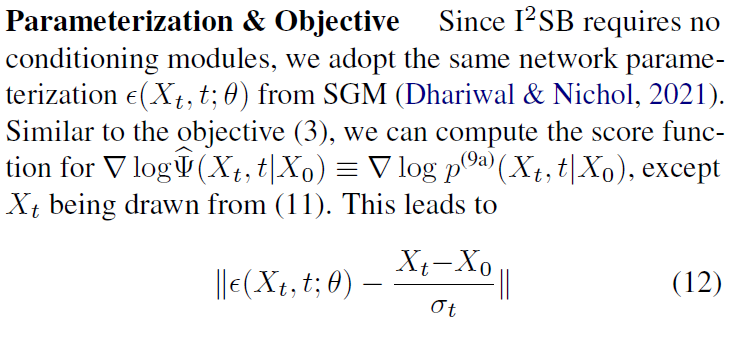


According to the paper Eq 12 is the objective. Networ ouput is the epsilon. Lets calculate the value that we will compare with network output.

In [54]:
def get_std_fwd(step, xdim=None):
        std_fwd_ = std_fwd[step]
        return std_fwd_ if xdim is None else unsqueeze_xdim(std_fwd_, xdim)

In [56]:
def compute_label(self, step, x0, xt):
        """ Eq 12 """
        std_fwd = get_std_fwd(step, xdim=x0.shape[1:])
        label = (xt - x0) / std_fwd
        return label.detach()

Lets compute the output from network

In [53]:
def compute_pred_x0(step, xt, net_out, clip_denoise=False):
        """ Given network output, recover x0. This should be the inverse of Eq 12 """
        std_fwd = get_std_fwd(step, xdim=xt.shape[1:])
        pred_x0 = xt - std_fwd * net_out
        if clip_denoise: pred_x0.clamp_(-1., 1.)
        return pred_x0

In [ ]:
#Quick sanity check
step = torch.randint(0, len(smp_betas), (x0.shape[0],))
xt = q_sample(step,x0,x1)
pred = net(xt, step) #this is very slow if it runs on CPU RAM is also not enough fo CoLab
smp_x0 = compute_pred_x0(step,xt, pred)

#Final Remarks

Rest of the code omitted because rest is depend on the training and coding nothin fancy addition as far as I understand. I explained below how it works.

First system determined the betas linear version is used but there are a lot of other options. Then standart deviation calcualted based on these betas for sampling. In the first diffusion additive gaussian noise to the inital image. But this paper implements a different technique to attain X_t. It is the function q_sample. It gets linearized version of nonlinear SDE :
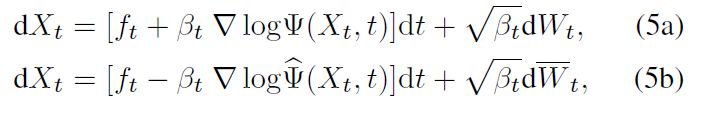

This indeed what schrödinger bridge considers. Thus by somehow makin tractable the forward process (see the paper for mathematical details). They created this q_sample formulation.

Then rest is prety similar diffusion where objective is given above also that

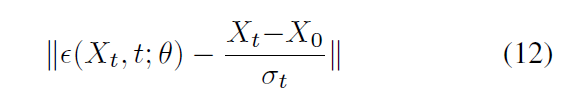

where epsilon is the U-Net output. Loss is the MSE.

They trained on the images by corrupting them by hand. See their github pages.